In [1]:
from math import floor, ceil
import numpy as np
from time import time
from glob import glob
from p_tqdm import p_umap
import pandas as pd
from random import shuffle
from glob import glob
import json
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style("white")
plt.rcParams['text.usetex'] = True

_precision = 1

def highlight_max(row, props=''):
    return np.where(row.round(_precision) == np.nanmax(row.values).round(_precision), props, '')

def highlight_min(row, props=''):
    return np.where(row.round(_precision) == np.nanmin(row.values).round(_precision), props, '')

def default_style(s):
    s.format(
        precision=_precision,
        na_rep="&mdash;",
        thousands=",",
    )
    s.set_table_styles(
        [
            {
                "selector": "td,th",
                "props": "border: 1px solid black; text-align: center",
            },
            {
                "selector": "td.data",
                "props": "text-align: right; font-family: 'monospace'",
            },            
            {
                "selector": "th",
                "props": "background-color: #D0D0D0 !important; font-weight: normal",
            },
            {
                "selector": "th.row_heading.level1, th.col_heading.level1",
                "props": "background-color: #E0E0E0 !important;",
            },
            {
                "selector": ".index_name,.col_heading.level0",
                "props": "font-weight: bold",
            },
            {
                "selector": ".blank",
                "props": "background-color: white",
            },
        ],
    )
    return s

In [2]:
data = pd.read_csv("results.csv")
data["instance"] = data["instance"].str.replace("miplib2017/", "")
data = data[data["method"] == "heuristic"]
data.loc[data["method"] == "heuristic", "method"] = "heuristic-86400"

data2 = pd.read_csv("../results-2022-11-28/results.csv")
data2["instance"] = data2["instance"].str.replace("miplib2017/", "")
data2.loc[data2["method"] == "heuristic", "method"] = "heuristic-900"
data2

data = pd.concat([data, data2])
data = data[data["orignodes"] > 1]
data

,instance,tree,method,compress,time,orignodes,newnodes
0,50v-10,RB,heuristic-86400,19.238076,16491.873590,10001,8077
2,CMS750_4,RB,heuristic-86400,99.990001,0.588224,10001,1
6,air05,RB,heuristic-86400,24.669604,31333.203228,227,171
8,app1-1,RB,heuristic-86400,98.410159,572.142582,10001,159
10,app1-2,RB,heuristic-86400,2.799720,86400.090769,10001,9721
...,...,...,...,...,...,...,...
292,uct-subprob,RB,drop,0.000000,0.775359,10001,10001
293,unitcal_7,RB,heuristic-900,0.039996,899.983178,10001,9997
294,unitcal_7,RB,drop,0.039996,1.138030,10001,9997
295,var-smallemery-m6j6,RB,heuristic-900,0.000000,900.034356,10001,10001


In [3]:
data["method"] = pd.Categorical(data["method"], ["drop", "heuristic-900", "heuristic-86400"])

In [6]:
summary = (
    data
        .groupby(["instance", "method"])
        .mean()
        .unstack()
        .dropna()
        .sort_values(by=("compress", "heuristic-86400"), ascending=False)
)
summary
summary.loc["mean", :] = summary.mean(axis=0)
df = summary.style.pipe(default_style)
df = df.apply(highlight_max, props='font-weight: bold; background-color: #ede', axis=1, subset="compress")
print(df.to_html())
# df

<style type="text/css">
#T_ce9c8 td {
  border: 1px solid black;
  text-align: center;
}
#T_ce9c8 th {
  border: 1px solid black;
  text-align: center;
}
#T_ce9c8 td.data {
  text-align: right;
  font-family: 'monospace';
}
#T_ce9c8 th {
  background-color: #D0D0D0 !important;
  font-weight: normal;
}
#T_ce9c8 th.row_heading.level1 {
  background-color: #E0E0E0 !important;
}
#T_ce9c8  th.col_heading.level1 {
  background-color: #E0E0E0 !important;
}
#T_ce9c8 .index_name {
  font-weight: bold;
}
#T_ce9c8 .col_heading.level0 {
  font-weight: bold;
}
#T_ce9c8 .blank {
  background-color: white;
}
#T_ce9c8_row0_col0, #T_ce9c8_row0_col1, #T_ce9c8_row0_col2, #T_ce9c8_row1_col0, #T_ce9c8_row1_col1, #T_ce9c8_row1_col2, #T_ce9c8_row2_col0, #T_ce9c8_row2_col1, #T_ce9c8_row2_col2, #T_ce9c8_row3_col0, #T_ce9c8_row3_col1, #T_ce9c8_row3_col2, #T_ce9c8_row4_col0, #T_ce9c8_row4_col1, #T_ce9c8_row4_col2, #T_ce9c8_row5_col0, #T_ce9c8_row5_col1, #T_ce9c8_row5_col2, #T_ce9c8_row6_col0, #T_ce9c8_row6_col1,

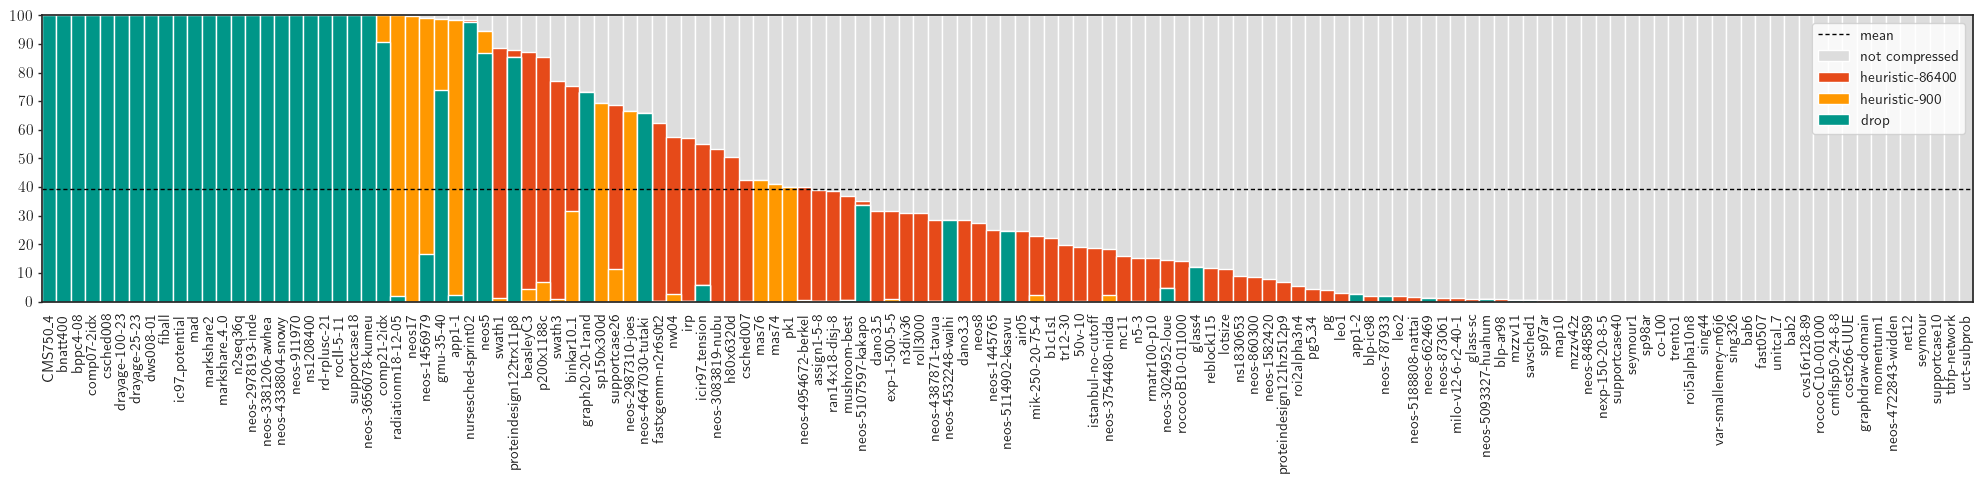

In [5]:
method_groups = {
    # "exact": [
    #     "drop",
    #     "supp:1",
    #     "supp:2",
    #     "supp:inf",
    # ],
    "heur": [
        "drop",
        "heuristic-900",
        "heuristic-86400",
    ]
}
method_colors = {
    "supp:inf": "#F44336", # red
    "supp:2": "#673AB7", # purple
    "supp:1": "#03A9F4", # blue
    "drop": "#009688", # green
    "heuristic": "#FF9800", # orange
    "heuristic-900": "#FF9800", # orange
    "heuristic-86400": "#E64A19", # orange
}

for tree in ["RB"]:
    for (methods_name, methods) in method_groups.items():
        filtered = data[data.tree == tree]
        filtered = filtered.groupby(["instance", "method"]).mean().reset_index()
        filtered = filtered.pivot("instance", "method", "compress")[methods]

        for (i, c) in enumerate(filtered.columns):
            if i > 0:
                filtered.iloc[:, i] = filtered.iloc[:, [i-1, i]].max(axis=1)
            filtered = filtered.sort_values(by=c, kind="stable", ascending=False)

        instances = list(filtered.index)

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
        plt.bar(instances, height=100.0, width=1.0, color="#ddd")
        colors = [method_colors[c] for c in filtered.columns[::-1]]
        mm = filtered[filtered.columns[-1]].mean()
        for (i, c) in enumerate(filtered.columns[::-1]):
            plt.bar(instances, height=filtered[c], width=1.0, color=colors[i])
        plt.axline((0, mm), (1, mm), color="black", dashes=(3,2), linewidth=1)

        plt.legend(
            ["mean", "not compressed"] + list(filtered.columns[::-1]),
            loc="upper right",
        )
        ax.tick_params(
            reset=True,
            axis="y",
            right=False,
            direction='out',
            length=3,
            width=1,
            # colors='r',
            # grid_color='r',
            # grid_alpha=0.5,
        )

        plt.xticks(rotation=90)
        plt.yticks(np.arange(0, 101, step=10))
        plt.margins(y=0, x=0)
        fig.tight_layout()
        plt.savefig(f"{tree}-{methods_name}.pdf")
        plt.savefig(f"{tree}-{methods_name}.png")